In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_hub as hub
import tensorflow_text as text
df_stock = pd.read_csv("maruti_suzuki/MARUTI.NS.csv",
                 parse_dates = ["Date"],
                 index_col = ["Date"])
df_posts = pd.read_excel("maruti_suzuki/maruti_suzuki_final_posts.xlsx")
# removing the unnecessary columns
df_posts.drop(["Unnamed: 0"], axis=1,inplace=True)
# removing spam posts
df_posts = df_posts[df_posts.Spam==0.0]
df_posts.drop(["Spam"],axis=1,inplace=True)
# sliding a window of 7 days and adding all the TIs
from stock_helper import prepare_data
x,y = prepare_data(df_stock)
final_x = x[np.datetime64("2021-11-13"):]
final_y = y[np.datetime64("2021-11-13"):]
# reversing the posts data
df_posts = df_posts[::-1]
final_posts = df_posts[7:]
# loading the sentiment analysis model
sent_model = tf.keras.models.load_model("final_bert")
# removing duplicates from the data
final_posts.drop_duplicates(subset=['Messages'])
# calculating the sentiments score
sentiments = []
prev = np.datetime64("2015-11-12 21:31:26")
for i in final_y.index:
    total=0
    cnt=0
    for j in final_posts.itertuples():
        _,msg,time = j
        if np.datetime64(time)<np.datetime64(i) and np.datetime64(time)>prev:
            total += tf.squeeze(sent_model.predict([msg])).numpy()
            cnt+=1
    prev = np.datetime64(i)
    if(cnt==0):
        sentiments.append(0)
    else:
        sentiments.append(total/cnt)
# getting indices where sentiments score is 0
zero_index = []
for i,j in enumerate(sentiments):
    if(j==0):
        zero_index.append(i)
# removing all the zero values indices
sentiments = np.delete(sentiments,zero_index)
final_x_zeros = final_x.copy()
final_y_zeros = final_y.copy()
final_y_zeros = final_y_zeros.to_frame()
final_x_zeros['removal_assist'] = np.arange(0,len(final_x),1)
final_y_zeros['removal_assist'] = np.arange(0,len(final_x),1)
final_y_zeros = final_y_zeros[final_y_zeros.removal_assist.isin(zero_index)==False]
final_x_zeros = final_x_zeros[final_x_zeros.removal_assist.isin(zero_index)==False]
# removing the added helper column
final_x_zeros.drop(["removal_assist"], axis=1,inplace=True)
final_y_zeros.drop(["removal_assist"], axis=1, inplace=True)

In [2]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
final_x_zeros_scaled = mms.fit_transform(final_x_zeros)
final_x_zeros_scaled

array([[0.41980076, 0.19144392, 0.17350197, ..., 0.57974905, 0.70709467,
        0.54999995],
       [0.36957264, 0.20892048, 0.2366209 , ..., 0.60375047, 0.7176312 ,
        0.54999995],
       [0.2905264 , 0.23642635, 0.33595848, ..., 0.5883486 , 0.6303451 ,
        0.54999995],
       ...,
       [0.95180225, 0.9424734 , 0.94618464, ..., 0.7914287 , 0.7590643 ,
        0.45      ],
       [0.96364975, 0.9706726 , 0.98105717, ..., 0.73870564, 0.7252364 ,
        0.45      ],
       [1.        , 1.        , 1.0000005 , ..., 0.668807  , 0.68463016,
        0.45      ]], dtype=float32)

In [3]:
k = final_y_zeros.max()
final_y_zeros= final_y_zeros/k

In [4]:
model_nbeats = tf.keras.models.load_model("nbeats_maruti suzuki")
model_nbeats.evaluate(final_x_zeros[50:],final_y_zeros[50:]*k)

1/1 [==============================] - 1s 812ms/step - loss: 310.5994 - mae: 310.5994 - mse: 127680.1328


[310.599365234375, 310.599365234375, 127680.1328125]

In [5]:
tf.random.set_seed(42)
inputs = tf.keras.layers.Input(shape=(71))
x = tf.keras.layers.Lambda(lambda x : tf.expand_dims(x,axis=1))(inputs)
x = tf.keras.layers.GRU(128, return_sequences=True)(x)
x = tf.keras.layers.GRU(128, return_sequences=True)(x)
x = tf.keras.layers.GRU(128)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.models.Model(inputs = inputs, outputs = outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 71)]              0         
                                                                 
 lambda (Lambda)             (None, 1, 71)             0         
                                                                 
 gru (GRU)                   (None, 1, 128)            77184     
                                                                 
 gru_1 (GRU)                 (None, 1, 128)            99072     
                                                                 
 gru_2 (GRU)                 (None, 128)               99072     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 275,457
Trainable params: 275,457
Non-trainable

In [6]:
model.compile(loss="mae",optimizer = tf.keras.optimizers.Adam(), metrics=["mae","mse"])
history = model.fit(final_x_zeros_scaled[:50],final_y_zeros[:50],
                    epochs = 1000,
                    validation_data = (final_x_zeros_scaled[50:], final_y_zeros[50:]),
                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                        patience=200, 
                                                        restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", 
                                                           patience=100, 
                                                           verbose=1)])

Epoch 1/1000
2/2 [==============================] - 5s 806ms/step - loss: 0.8202 - mae: 0.8202 - mse: 0.6777 - val_loss: 0.6735 - val_mae: 0.6735 - val_mse: 0.4541 - lr: 0.0010
Epoch 2/1000
2/2 [==============================] - 0s 41ms/step - loss: 0.6067 - mae: 0.6067 - mse: 0.3751 - val_loss: 0.2771 - val_mae: 0.2771 - val_mse: 0.0774 - lr: 0.0010
Epoch 3/1000
2/2 [==============================] - 0s 41ms/step - loss: 0.3354 - mae: 0.3354 - mse: 0.1248 - val_loss: 0.2958 - val_mae: 0.2958 - val_mse: 0.0884 - lr: 0.0010
Epoch 4/1000
2/2 [==============================] - 0s 40ms/step - loss: 0.1713 - mae: 0.1713 - mse: 0.0455 - val_loss: 0.7033 - val_mae: 0.7033 - val_mse: 0.4957 - lr: 0.0010
Epoch 5/1000
2/2 [==============================] - 0s 42ms/step - loss: 0.2847 - mae: 0.2847 - mse: 0.1307 - val_loss: 0.5549 - val_mae: 0.5549 - val_mse: 0.3087 - lr: 0.0010
Epoch 6/1000
2/2 [==============================] - 0s 47ms/step - loss: 0.1956 - mae: 0.1956 - mse: 0.0678 - val_loss:

2/2 [==============================] - 0s 33ms/step - loss: 0.0116 - mae: 0.0116 - mse: 2.2233e-04 - val_loss: 0.0247 - val_mae: 0.0247 - val_mse: 6.8689e-04 - lr: 0.0010
Epoch 47/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0129 - mae: 0.0129 - mse: 2.5997e-04 - val_loss: 0.0112 - val_mae: 0.0112 - val_mse: 1.5986e-04 - lr: 0.0010
Epoch 48/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.0146 - mae: 0.0146 - mse: 2.7594e-04 - val_loss: 0.0287 - val_mae: 0.0287 - val_mse: 8.9308e-04 - lr: 0.0010
Epoch 49/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0100 - mae: 0.0100 - mse: 1.6701e-04 - val_loss: 0.0100 - val_mae: 0.0100 - val_mse: 1.3298e-04 - lr: 0.0010
Epoch 50/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0112 - mae: 0.0112 - mse: 1.9914e-04 - val_loss: 0.0335 - val_mae: 0.0335 - val_mse: 0.0012 - lr: 0.0010
Epoch 51/1000
2/2 [==============================] - 0s 38ms/step - loss: 0.0130 - mae: 0.013

2/2 [==============================] - 0s 33ms/step - loss: 0.0212 - mae: 0.0212 - mse: 5.5787e-04 - val_loss: 0.0084 - val_mae: 0.0084 - val_mse: 1.1620e-04 - lr: 0.0010
Epoch 91/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0226 - mae: 0.0226 - mse: 6.1876e-04 - val_loss: 0.0067 - val_mae: 0.0067 - val_mse: 7.4632e-05 - lr: 0.0010
Epoch 92/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0171 - mae: 0.0171 - mse: 3.7669e-04 - val_loss: 0.0418 - val_mae: 0.0418 - val_mse: 0.0018 - lr: 0.0010
Epoch 93/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0189 - mae: 0.0189 - mse: 4.4699e-04 - val_loss: 0.0057 - val_mae: 0.0057 - val_mse: 5.2059e-05 - lr: 0.0010
Epoch 94/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0168 - mae: 0.0168 - mse: 3.6391e-04 - val_loss: 0.0093 - val_mae: 0.0093 - val_mse: 1.1528e-04 - lr: 0.0010
Epoch 95/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0117 - mae: 0.011

2/2 [==============================] - 0s 32ms/step - loss: 0.0068 - mae: 0.0068 - mse: 6.7632e-05 - val_loss: 0.0268 - val_mae: 0.0268 - val_mse: 7.5775e-04 - lr: 0.0010
Epoch 135/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0081 - mae: 0.0081 - mse: 9.7649e-05 - val_loss: 0.0137 - val_mae: 0.0137 - val_mse: 2.2408e-04 - lr: 0.0010
Epoch 136/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0101 - mae: 0.0101 - mse: 1.5481e-04 - val_loss: 0.0333 - val_mae: 0.0333 - val_mse: 0.0011 - lr: 0.0010
Epoch 137/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0123 - mae: 0.0123 - mse: 1.8076e-04 - val_loss: 0.0069 - val_mae: 0.0069 - val_mse: 5.7768e-05 - lr: 0.0010
Epoch 138/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.0099 - mae: 0.0099 - mse: 1.2530e-04 - val_loss: 0.0214 - val_mae: 0.0214 - val_mse: 4.9183e-04 - lr: 0.0010
Epoch 139/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0042 - mae: 

2/2 [==============================] - 0s 30ms/step - loss: 0.0137 - mae: 0.0137 - mse: 2.3021e-04 - val_loss: 0.0332 - val_mae: 0.0332 - val_mse: 0.0012 - lr: 0.0010
Epoch 179/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0094 - mae: 0.0094 - mse: 1.3030e-04 - val_loss: 0.0199 - val_mae: 0.0199 - val_mse: 4.4462e-04 - lr: 0.0010
Epoch 180/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0061 - mae: 0.0061 - mse: 5.7702e-05 - val_loss: 0.0228 - val_mae: 0.0228 - val_mse: 5.6566e-04 - lr: 0.0010
Epoch 181/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0047 - mae: 0.0047 - mse: 4.4279e-05 - val_loss: 0.0196 - val_mae: 0.0196 - val_mse: 4.2748e-04 - lr: 0.0010
Epoch 182/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0052 - mae: 0.0052 - mse: 4.0291e-05 - val_loss: 0.0274 - val_mae: 0.0274 - val_mse: 7.9015e-04 - lr: 0.0010
Epoch 183/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0045 - mae: 

2/2 [==============================] - 0s 31ms/step - loss: 0.0032 - mae: 0.0032 - mse: 1.9463e-05 - val_loss: 0.0205 - val_mae: 0.0205 - val_mse: 4.5232e-04 - lr: 0.0010
Epoch 223/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0031 - mae: 0.0031 - mse: 2.1890e-05 - val_loss: 0.0223 - val_mae: 0.0223 - val_mse: 5.3007e-04 - lr: 0.0010
Epoch 224/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0039 - mae: 0.0039 - mse: 2.9548e-05 - val_loss: 0.0232 - val_mae: 0.0232 - val_mse: 5.7043e-04 - lr: 0.0010
Epoch 225/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0044 - mae: 0.0044 - mse: 3.5350e-05 - val_loss: 0.0266 - val_mae: 0.0266 - val_mse: 7.4043e-04 - lr: 0.0010
Epoch 226/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0058 - mae: 0.0058 - mse: 5.3606e-05 - val_loss: 0.0190 - val_mae: 0.0190 - val_mse: 3.9093e-04 - lr: 0.0010
Epoch 227/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0031 - m

2/2 [==============================] - 0s 32ms/step - loss: 0.0030 - mae: 0.0030 - mse: 1.9012e-05 - val_loss: 0.0198 - val_mae: 0.0198 - val_mse: 4.2508e-04 - lr: 1.0000e-04
Epoch 266/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0029 - mae: 0.0029 - mse: 1.7389e-05 - val_loss: 0.0171 - val_mae: 0.0171 - val_mse: 3.2439e-04 - lr: 1.0000e-04
Epoch 267/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0029 - mae: 0.0029 - mse: 1.5857e-05 - val_loss: 0.0166 - val_mae: 0.0166 - val_mse: 3.1053e-04 - lr: 1.0000e-04
Epoch 268/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0028 - mae: 0.0028 - mse: 1.5323e-05 - val_loss: 0.0187 - val_mae: 0.0187 - val_mse: 3.8150e-04 - lr: 1.0000e-04
Epoch 269/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.0027 - mae: 0.0027 - mse: 1.5996e-05 - val_loss: 0.0203 - val_mae: 0.0203 - val_mse: 4.4322e-04 - lr: 1.0000e-04
Epoch 270/1000
2/2 [==============================] - 0s 32ms/ste

2/2 [==============================] - 0s 31ms/step - loss: 0.0022 - mae: 0.0022 - mse: 1.3231e-05 - val_loss: 0.0186 - val_mae: 0.0186 - val_mse: 3.7796e-04 - lr: 1.0000e-04
Epoch 309/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0023 - mae: 0.0023 - mse: 1.2989e-05 - val_loss: 0.0193 - val_mae: 0.0193 - val_mse: 4.0528e-04 - lr: 1.0000e-04
Epoch 310/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0024 - mae: 0.0024 - mse: 1.4167e-05 - val_loss: 0.0196 - val_mae: 0.0196 - val_mse: 4.1312e-04 - lr: 1.0000e-04
Epoch 311/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0022 - mae: 0.0022 - mse: 1.3678e-05 - val_loss: 0.0178 - val_mae: 0.0178 - val_mse: 3.4798e-04 - lr: 1.0000e-04
Epoch 312/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0026 - mae: 0.0026 - mse: 1.3344e-05 - val_loss: 0.0188 - val_mae: 0.0188 - val_mse: 3.8572e-04 - lr: 1.0000e-04
Epoch 313/1000
2/2 [==============================] - 0s 33ms/ste

2/2 [==============================] - 0s 30ms/step - loss: 0.0022 - mae: 0.0022 - mse: 1.2847e-05 - val_loss: 0.0193 - val_mae: 0.0193 - val_mse: 4.0261e-04 - lr: 1.0000e-04
Epoch 352/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0022 - mae: 0.0022 - mse: 1.2572e-05 - val_loss: 0.0190 - val_mae: 0.0190 - val_mse: 3.9214e-04 - lr: 1.0000e-04
Epoch 353/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0021 - mae: 0.0021 - mse: 1.2947e-05 - val_loss: 0.0203 - val_mae: 0.0203 - val_mse: 4.4099e-04 - lr: 1.0000e-04
Epoch 354/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0024 - mae: 0.0024 - mse: 1.8135e-05
Epoch 00354: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
2/2 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.0022 - mse: 1.3576e-05 - val_loss: 0.0188 - val_mae: 0.0188 - val_mse: 3.8468e-04 - lr: 1.0000e-04


In [7]:
preds = tf.squeeze(model.predict(final_x_zeros_scaled[50:])).numpy()
preds = preds*k.values[0]
preds

array([8766.409, 8624.287, 8584.201, 8574.237, 8517.011, 8597.31 ,
       8564.397, 8577.385, 8662.956, 8836.088, 8747.038, 8682.091],
      dtype=float32)

In [8]:
mae = sum(abs(preds-(tf.squeeze(final_y_zeros[50:].to_numpy()).numpy())*k.values[0]))
mae

530.4052734375

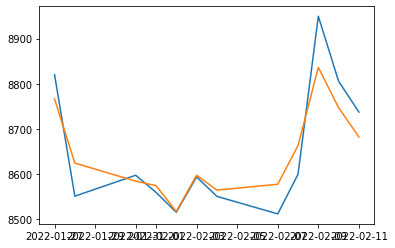

In [9]:
plt.plot(final_y_zeros.index[50:], (tf.squeeze(final_y_zeros[50:].to_numpy()).numpy())*k.values[0])
plt.plot(final_y_zeros.index[50:], preds)

In [10]:
model.save("GRU_maruti suzuki")

INFO:tensorflow:Assets written to: GRU_maruti suzuki\assets


INFO:tensorflow:Assets written to: GRU_maruti suzuki\assets
